In [1]:
#!wget https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv

In [2]:
#load library
import pandas as pd

In [3]:
# reading dataset
df = pd.read_csv('train.tsv',sep='\t')
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [4]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
train_csv,val_csv = train_test_split(df,test_size=0.3,random_state=2003)
train_csv.to_csv('train.csv',index=False)
val_csv.to_csv('validation.csv',index=False)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext.data import Field,LabelField
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesPoutyne

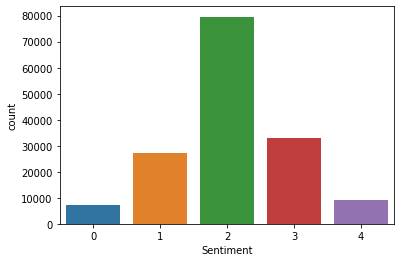

In [6]:
# Plot distibution
sns.countplot('Sentiment',data=df).get_figure().savefig('dist')

In [7]:
# Label and text beild
TEXT = Field(sequential=True,use_vocab=True,lower=True,tokenize='spacy',tokenizer_language='en',batch_first=True,fix_length=53,init_token='SOS',eos_token='EOS'
             ,preprocessing=lambda x: ['SOS'] + x +['EOS'])
LABEL = LabelField(batch_first=True)

In [8]:
train_data,valid_data = torchtext.data.TabularDataset.splits('.',train='train.csv',validation='validation.csv',format='CSV',fields=[('PhraseId',None),('SentenceId',None),('Phrase',TEXT),('Sentiment',LABEL)],skip_header=True)

In [9]:
# TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors("../input/embeddings/glove.840B.300d/glove.840B.300d.txt"), 
#                  max_size=20000, min_freq=10)
# Building Vocab from train set
TEXT.build_vocab(train_data,min_freq=3,vectors='glove.6B.50d')

In [10]:
# build vocab
LABEL.build_vocab(train_data)

In [11]:
# Building Iteator 
from torchtext.data import Iterator, BucketIterator
bs=128
train_data_iterator = Iterator(train_data,batch_size=bs,train=True,shuffle=True,device='cuda')
val_data_iterator = Iterator(valid_data,batch_size=2*bs,train=True,shuffle=False,device='cuda')

In [12]:
# get index of pad token so that we do not calculate gradient for it
PAD = TEXT.vocab.stoi['<pad>']
TEXT.vocab.stoi['<pad>'],TEXT.vocab.itos[1]

(1, '<pad>')

In [13]:
# Building the Model
class Classifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes):
        super(Classifier, self).__init__()
        self.embedding = torch.nn.Embedding(len(TEXT.vocab),50,padding_idx=PAD)
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels, 
                      out_channels=64, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=64, out_channels=100, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=100, out_channels=128, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=128, out_channels=150, 
                      kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=150, out_channels=200, 
                      kernel_size=3,stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=200, out_channels=256, 
                      kernel_size=3,stride=2),
            nn.ELU(),
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x, apply_softmax=False):
        x = self.embedding(x)
        features = self.convnet(x).squeeze(dim=2)
        #print(features.shape)
        prediction_vector = self.fc(features)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [14]:
# Initialize Model
m = Classifier(53,5)
m

Classifier(
  (embedding): Embedding(15321, 50, padding_idx=1)
  (convnet): Sequential(
    (0): Conv1d(53, 64, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(64, 100, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(100, 128, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(128, 150, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
    (8): Conv1d(150, 200, kernel_size=(3,), stride=(2,))
    (9): ELU(alpha=1.0)
    (10): Conv1d(200, 256, kernel_size=(3,), stride=(2,))
    (11): ELU(alpha=1.0)
  )
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [15]:
from poutyne.framework import Model
from poutyne.framework.metrics import FBeta,F1

# Loading pretrained GLOVE Weights
m.embedding.weights =TEXT.vocab.vectors

# Defining Metrics, Loss and Optimizer
model = Model(m,'ADAM',loss_function='cross_entropy',
              batch_metrics=['accuracy'], epoch_metrics=[F1(),FBeta('recall'),FBeta('precision')],)
model.to(0)

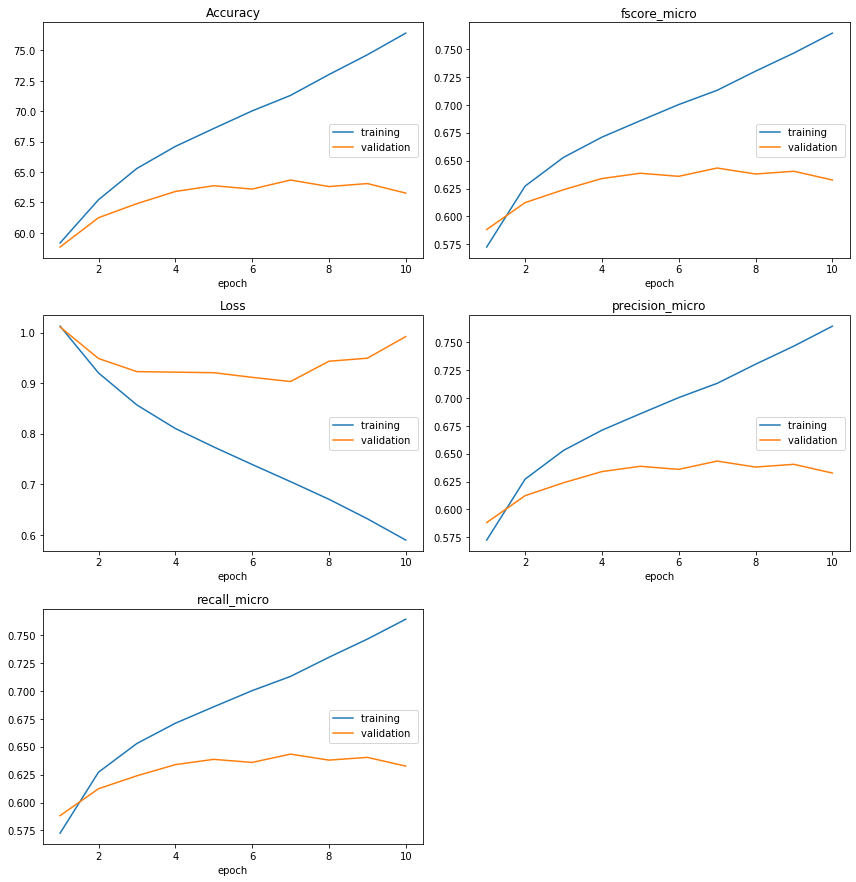

Accuracy
	training         	 (min:   51.754, max:   76.419, cur:   76.419)
	validation       	 (min:   53.422, max:   64.336, cur:   63.264)
fscore_micro
	training         	 (min:    0.518, max:    0.764, cur:    0.764)
	validation       	 (min:    0.534, max:    0.643, cur:    0.633)
Loss
	training         	 (min:    0.590, max:    1.214, cur:    0.590)
	validation       	 (min:    0.903, max:    1.171, cur:    0.992)
precision_micro
	training         	 (min:    0.518, max:    0.764, cur:    0.764)
	validation       	 (min:    0.534, max:    0.643, cur:    0.633)
recall_micro
	training         	 (min:    0.518, max:    0.764, cur:    0.764)
	validation       	 (min:    0.534, max:    0.643, cur:    0.633)


[{'epoch': 1,
  'loss': 1.0126935464124438,
  'time': 16.31806830200003,
  'acc': 59.16314238015771,
  'fscore_micro': 0.572611927986145,
  'recall_micro': 0.572611927986145,
  'precision_micro': 0.572611927986145,
  'val_loss': 1.0111282942280713,
  'val_acc': 58.82780127888116,
  'val_fscore_micro': 0.5882779955863953,
  'val_recall_micro': 0.5882779955863953,
  'val_precision_micro': 0.5882779955863953},
 {'epoch': 2,
  'loss': 0.9202123911072034,
  'time': 16.35387742199964,
  'acc': 62.717636074386654,
  'fscore_micro': 0.6271763443946838,
  'recall_micro': 0.6271763443946838,
  'precision_micro': 0.6271763443946838,
  'val_loss': 0.948788071255177,
  'val_acc': 61.23713102971755,
  'val_fscore_micro': 0.6123713254928589,
  'val_recall_micro': 0.6123713254928589,
  'val_precision_micro': 0.6123713254928589},
 {'epoch': 3,
  'loss': 0.8568432826617495,
  'time': 16.66841889599982,
  'acc': 65.2908222094216,
  'fscore_micro': 0.652908205986023,
  'recall_micro': 0.652908205986023,
 

In [20]:
# Train
model.fit_generator(train_data_iterator,val_data_iterator,epochs=10,callbacks=[PlotLossesPoutyne()],verbose=False)

In [22]:
# File name of saved model
filename = '1117021_1dconv_reg.pt'

In [21]:
# save model
#model.save_weights(filename)

In [23]:
# Load model
model.load_weights(filename)

In [24]:
# Evalute
model.evaluate_generator(val_data_iterator)

(0.9921585625802454,
 array([63.26412919,  0.63264132,  0.63264132,  0.63264132]))